# Forudsigelse af tidsserier
I denne notebook ses på hvordan tidserier som f.eks. sensordata med sæsonmæssig variation kan forudsiges ved hjælp af [Prophet](https://facebook.github.io/prophet/). Prophet er en ikke lineær model som tager højde for tendens, sæson og feriedage. Læs nærmere om modelleringen i denne [artikel](https://peerj.com/preprints/3190.pdf) . Notebooken er opdelt i tre dele: input, model og output hvor data henholdsvis klargøres, hældes ind i forudsigelsesmodellen og eksporteres til f.eks. CSV eller en PostgreSQL database.
1. [Input](#Input)
2. [Model](#Model)
3. [Output](#Output)

In [2]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt
import psycopg2
from sqlalchemy import create_engine
%matplotlib inline

Forbindelse til postgres

In [4]:
import sys
sys.path.insert(0, '../../automation-scripts/Python/')
from config import config

# Input

Hent data og gem som CSV

In [7]:
con = create_engine(config['databases']['grazper'])
df = pd.read_sql_table('road-car-00:04:4b:a5:15:ec', con)
df.to_csv('data.csv')

Brug CSV

In [15]:
df = pd.read_csv('data.csv')
df.drop(columns=['Unnamed: 0', 'id'], inplace=True)
df['time'] = pd.to_datetime(df['time'],unit='ms')
df.set_index('time', inplace=True)

Resample data til timesintervaller

In [16]:
rs = df.resample('60T').count()
rs.reset_index(inplace=True)
rs.columns = ['ds', 'y']

Der er en del huller dataindsamlingen, som det ses herunder i februar måned

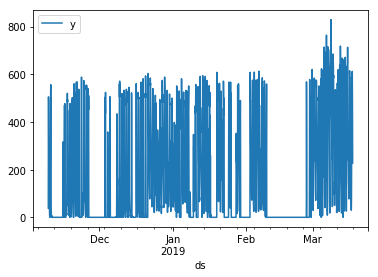

In [39]:
rs.set_index('ds').plot()

# Model

In [32]:
m = Prophet()
m.fit(rs.tail(400))

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/Users/andersbarfod/anaconda/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Laver tidserie som rækker en uge længere end data datasættet

In [33]:
future = m.make_future_dataframe(periods=24, freq='H')

Laver præriktion

In [34]:
forecast = m.predict(future)

In [38]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(50)

,ds,yhat,yhat_lower,yhat_upper
374,2019-03-16 17:00:00,420.263060,272.055612,554.607248
375,2019-03-16 18:00:00,330.063467,190.390749,471.276602
376,2019-03-16 19:00:00,255.273340,120.731225,382.282982
377,2019-03-16 20:00:00,201.842295,52.803716,331.950657
378,2019-03-16 21:00:00,163.393654,24.250489,297.952428
379,2019-03-16 22:00:00,127.827477,-9.207845,268.878804
380,2019-03-16 23:00:00,85.401152,-53.211386,228.706347
381,2019-03-17 00:00:00,35.363861,-100.509837,175.270312
382,2019-03-17 01:00:00,-10.994747,-154.011506,134.820352
383,2019-03-17 02:00:00,-33.118988,-158.975486,110.031191


### Visalisering

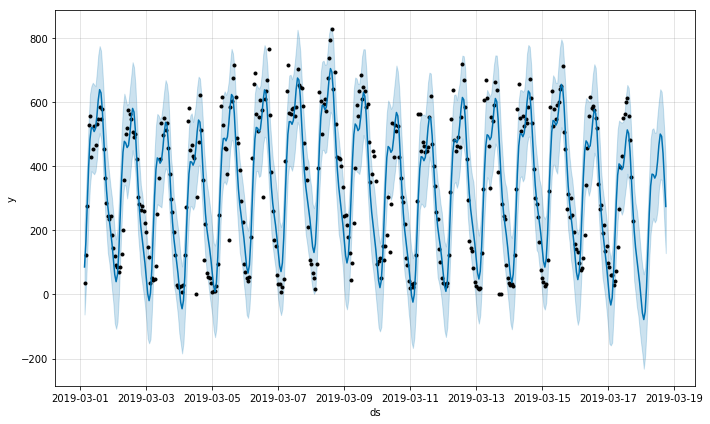

In [36]:
fig1 = m.plot(forecast, uncertainty=True)

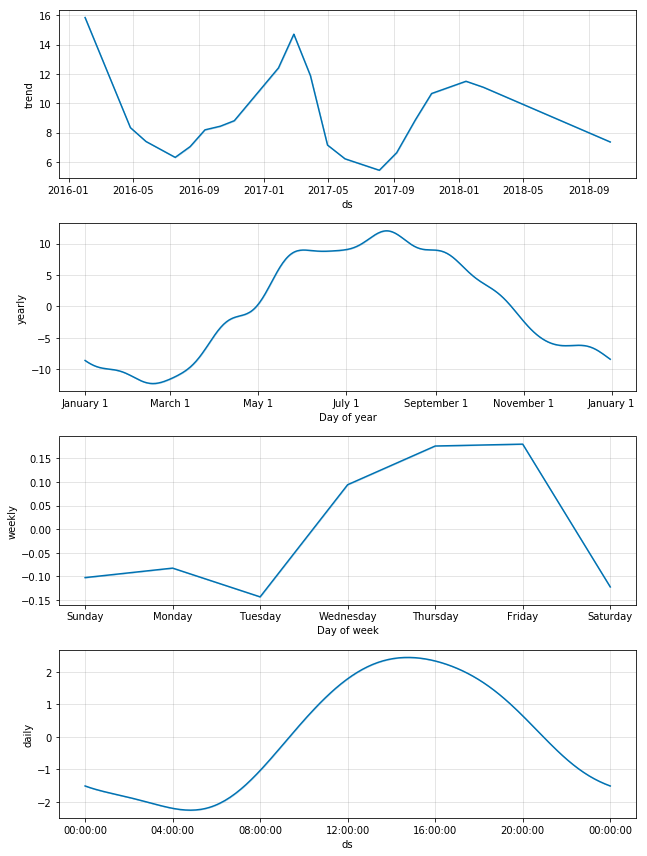

In [84]:
fig2 = m.plot_components(forecast)

### Merge

In [10]:
merge = df.merge(forecast, left_on='ds', right_on='ds', how='right')

In [11]:
merge.set_index('ds', inplace=True)

In [12]:
merge['diff'] = merge['y'] - merge['yhat']

In [13]:
merge[['y', 'yhat', 'diff']].head(100)

,y,yhat,diff
ds,,,
2016-02-01 00:00:00,1.0,3.369324,-2.369324
2016-02-01 01:00:00,1.0,3.158063,-2.158063
2016-02-01 02:00:00,1.0,2.985655,-1.985655
2016-02-01 03:00:00,2.0,2.796479,-0.796479
2016-02-01 04:00:00,1.0,2.618399,-1.618399
2016-02-01 05:00:00,1.0,2.549443,-1.549443
2016-02-01 06:00:00,1.0,2.693893,-1.693893
2016-02-01 07:00:00,1.0,3.096689,-2.096689
2016-02-01 08:00:00,1.0,3.720092,-2.720092


# Output

Sender data over til PostgreSQL

Tager kun sidste 1000 rækker hvor prognosen indgår

In [17]:
merge[['y', 'yhat', 'diff', 'yhat_lower', 'yhat_upper']].tail(1000).to_sql('temperatur_forecast', con=con)